In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import egg.core as core

from typing import Any, List, Optional, Sequence, Union

import torch.utils.data
from torch_geometric.data import Batch, Dataset, Data
from torch_geometric.data.data import BaseData
from torch_geometric.data.datapipes import DatasetAdapter
from torch_geometric.data.on_disk_dataset import OnDiskDataset

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataclasses import dataclass

@dataclass
class Options:
    # Agents
    embedding_size: int = 40 # Default: 50
    heads: int = 2 # Default: 1
    hidden_size: int = 20 # Default: 20
    sender_cell: str = 'gru' # 'rnn', 'gru', 'lstm'
    max_len: int = 4 # Default: 1
    gs_tau: int = 1.0 # Default: 1.0

    # Training
    n_epochs: int = 5
    vocab_size: int = 100 # Default: 100
    batch_size: int = 1 

opts = Options()

In [3]:
import random
import torch
from torch_geometric.data import Data

class FamilyMember:
    """
    Represents a family member with gender, age, spouse, and children.
    """

    def __init__(self, gender, age):
        self.gender = gender
        self.age = age
        self.spouse = None
        self.children = []
        self.height = random.randint(150, 200) # in cm
        self.hair_color = random.choice(['black', 'brown', 'blonde', 'red'])

    def create_spouse(self):
        """
        Creates a spouse for the family member based on their gender and age.
        Returns the created spouse.
        """
        spouse_gender = 'f' if self.gender == 'm' else 'm'
        spouse_age = random.randint(max(18, self.age - 5), min(self.age + 5, 100))
        spouse = FamilyMember(spouse_gender, spouse_age)
        self.spouse = spouse
        spouse.spouse = self
        return spouse

    def create_children(self, max_children=4):
        """
        Creates children for the family member and their spouse.
        """
        children_count = 2 #random.randint(1, max_children) # Set this to a integer for graphs of same size
        youngest_parent_age = min(self.age, self.spouse.age)
        for _ in range(children_count):
            child_gender = random.choice(['m', 'f'])
            max_child_age = max(0, youngest_parent_age - 20)
            min_child_age = max(0, youngest_parent_age - 30)
            child_age = random.randint(min_child_age, max_child_age)
            child = FamilyMember(child_gender, child_age)
            self.children.append(child)
            self.spouse.children.append(child)

def create_family_tree(generations):
    age_range = (80,100)
    root_age = random.randint(*age_range)
    root_member = FamilyMember('m', root_age)

    spouse = root_member.create_spouse()
    current_generation = [(root_member, spouse)]
    
    all_members = {0: root_member, 1: spouse}
    next_index = 2  # Start indexing from 2 as 0 and 1 are already used

    for gen in range(1, generations):
        next_generation = []
        for parent1, parent2 in current_generation:
            parent1.create_children()
            for child in parent1.children:
                all_members[next_index] = child
                next_index += 1
                if gen < generations - 1:
                    spouse = child.create_spouse()
                    all_members[next_index] = spouse
                    next_generation.append((child, spouse))
                    next_index += 1
        current_generation = next_generation

    return all_members

def create_data_object(all_members):
    # Convert genders to a binary representation and collect node features
    gender_to_binary = {'m': 0, 'f': 1}
    color_to_binary = {'black': 0, 'brown': 1, 'blonde': 2, 'red': 3}
    x = [[gender_to_binary[member.gender], member.age, color_to_binary[member.hair_color], member.height] for index, member in all_members.items()]

    # Prepare edge_index and edge_attr
    edge_index = []
    edge_attr = []

    for index, member in all_members.items():
        if member.spouse:
            spouse_index = list(all_members.keys())[list(all_members.values()).index(member.spouse)]
            # Add edges for spouses in both directions with the 'married' attribute
            edge_index.append([index, spouse_index])
            edge_index.append([spouse_index, index])
            edge_attr.extend([0, 0])  # 0 for 'married'

        for child in member.children:
            child_index = list(all_members.keys())[list(all_members.values()).index(child)]
            # Add edges from children to this member with the 'childOf' attribute
            edge_index.append([child_index, index])
            edge_attr.append(1)  # 1 for 'childOf'

    # Convert to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Create the data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data

In [4]:
import os
import torch
import random
from torch_geometric.data import Dataset

class FamilyGraphDataset(Dataset):
    """
    Dataset class for generating family graph data.

    Args:
        root (str): Root directory path.
        number_of_graphs (int): Number of graphs to generate.
        generations (int): Number of generations in each family tree.

    Returns:
        Data(x=[8, 2], edge_index=[2, 20], edge_attr=[20], labels=[8])
    """
    def __init__(self, root, number_of_graphs, generations, transform=None, pre_transform=None):
        self.number_of_graphs = number_of_graphs
        self.generations = generations
        super(FamilyGraphDataset, self).__init__(root, transform, pre_transform)
        self.data = None
        self.process()

    @property
    def processed_file_names(self):
        return ['family_graphs.pt']

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]
    
    def generate_labels(self, num_nodes):
        target_node_idx = random.randint(0, num_nodes - 1)
        return target_node_idx
    
    def generate_root(self, num_nodes, target_node_idx):
        node_indices = list(range(num_nodes))
        node_indices.remove(target_node_idx)
        root_idx = random.choice(node_indices)
        return root_idx
    
    def process(self):
        if not os.path.isfile(self.processed_paths[0]):
            self.data = []
            for _ in range(self.number_of_graphs):
                family_tree = create_family_tree(self.generations)
                graph_data = create_data_object(family_tree)

                # Generate random labels for each node
                target_node_idx = self.generate_labels(graph_data.num_nodes)

                # Store the labels as an attribute of the graph_data
                graph_data.target_node_idx = target_node_idx

                root_idx = self.generate_root(graph_data.num_nodes, target_node_idx)

                graph_data.root_idx = root_idx

                self.data.append(graph_data)

            torch.save(self.data, self.processed_paths[0])
        else:
            self.data = torch.load(self.processed_paths[0])

In [5]:
dataset = FamilyGraphDataset(root='/Users/meeslindeman/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Code/data', number_of_graphs=100, generations=3)
print(dataset[0])
print(dataset[1])

Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=2, root_idx=3)
Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=2, root_idx=0)


In [6]:
total_nodes = 0
for i in range(0, len(dataset)):
    total_nodes += dataset[i].x.shape[0]  # shape[0] gives the number of nodes in each graph

average_nodes = total_nodes / len(dataset)
print("Average number of nodes:", average_nodes)

Average number of nodes: 4.0


In [7]:
graph = dataset[0]
print(*graph, sep="\n")

('x', tensor([[  0.,  82.,   1., 190.],
        [  1.,  81.,   0., 187.],
        [  1.,  53.,   1., 169.],
        [  1.,  55.,   3., 189.]]))
('edge_index', tensor([[0, 1, 2, 3, 1, 0, 2, 3],
        [1, 0, 0, 0, 0, 1, 1, 1]]))
('edge_attr', tensor([0., 0., 1., 1., 0., 0., 1., 1.]))
('target_node_idx', 2)
('root_idx', 3)


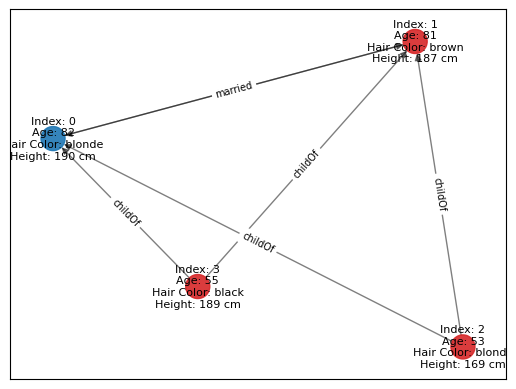

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(data):
    """
    Draw a directed graph based on the given data.

    Parameters:
    data (object): The data object containing the necessary information for drawing the graph.
    """

    # Create a new directed graph
    G = nx.DiGraph()

    # Add nodes with only age attributes (since names are not used)
    for i, attr in enumerate(data.x):
        G.add_node(i, age=int(attr[1]), hair=int(attr[2]), height=int(attr[3]))

    # Add edges and edge labels based on the edge_index and edge_attr from PyG data
    edge_labels = {}
    for start, end, attr in zip(data.edge_index[0], data.edge_index[1], data.edge_attr):
        G.add_edge(start.item(), end.item())
        # Use 'married' or 'childOf' based on the edge_attr
        edge_labels[(start.item(), end.item())] = 'married' if attr.item() == 0 else 'childOf'

    # Define node colors: 'blue' for male, 'red' for female
    node_colors = ['tab:blue' if gender == 0 else 'tab:red' for gender, _, _, _ in data.x.tolist()]

    # Position nodes using spring layout
    pos = nx.spring_layout(G)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.9)

    # Draw the directed edges (arrows)
    nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.5)

    # Draw the edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # Draw the node labels with index and age
    labels = {i: f"Index: {i}\nAge: {int(data.x[i, 1])}\nHair Color: {'brown' if data.x[i, 2] == 0 else 'blonde' if data.x[i, 2] == 1 else 'black'}\nHeight: {int(data.x[i, 3])} cm" for i in range(len(data.x))}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)  # Adjust font size as needed

    # Show the plot
    plt.show()

plot = draw_graph(dataset[0])

In [9]:
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        # self.conv1 = GATv2Conv((embedding_size * heads), embedding_size, edge_dim=0, heads=heads, concat=True)
        self.conv1 = GATv2Conv(num_node_features, embedding_size, edge_dim=0, heads=heads, concat=True)
        self.conv2 = GATv2Conv(-1, embedding_size, edge_dim=0, heads=heads, concat=True)

    def forward(self, data):
        # _, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = F.dropout(h, training=self.training)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h
    
from torch_geometric.nn import TransformerConv

class Transform(torch.nn.Module):
    def __init__(self, num_node_features, embedding_size, heads):
        super().__init__()
        self.conv1 = TransformerConv(num_node_features, embedding_size, edge_dim=0, heads=heads, concat=True)
        self.conv2 = TransformerConv(-1, embedding_size, edge_dim=0, heads=heads, concat=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        h = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        h = F.dropout(h, training=self.training)

        h = self.conv2(x=h, edge_index=edge_index, edge_attr=edge_attr)     
        h = F.relu(h)

        return h

In [10]:
class SenderDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h_t = self.transform(data)

       # h = self.gat(data, h_t)

        h_g = self.gat(data)

        h = h_t + h_g

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverDual(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverDual, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h_t = self.transform(data)

        # h = self.gat(data, h_t)

        h_g = self.gat(data)

        h = h_t + h_g   

        message_embedding = self.fc(message)        

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [11]:
class SenderGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature

        self.gat = GAT(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.gat(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverGAT(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverGAT, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size

        self.gat = GAT(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.gat(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

In [12]:
class SenderTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature
          
        self.transform = Transform(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads), hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx = data.target_node_idx

        h = self.transform(data)

        target_embedding = h[target_node_idx]           

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverTransform(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverTransform, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        
        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.transform(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities

## Message Passing (Relationship)

In [13]:
class SenderRel(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size, temperature):
        super(SenderRel, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        self.hidden_size = hidden_size
        self.temp = temperature
          
        self.transform = Transform(self.num_node_features, embedding_size, heads) 
        self.fc = nn.Linear((embedding_size * heads) * 2, hidden_size) 

    def forward(self, x, _aux_input):
        data = _aux_input

        target_node_idx, root_idx = data.target_node_idx, data.root_idx

        h = self.transform(data)

        target = h[target_node_idx].squeeze()
        root = h[root_idx].squeeze()

        target_embedding = torch.cat((target, root))    

        output = self.fc(target_embedding)                           

        return output.view(-1, self.hidden_size)

class ReceiverRel(nn.Module):
    def __init__(self, embedding_size, heads, hidden_size):
        super(ReceiverRel, self).__init__()
        self.num_node_features = dataset.num_node_features
        self.heads = heads
        
        self.transform = Transform(self.num_node_features, embedding_size, heads)
        self.fc = nn.Linear(hidden_size, (embedding_size * heads))

    def forward(self, message, _input, _aux_input):
        data = _aux_input

        h = self.transform(data)   

        message_embedding = self.fc(message)                 

        dot_products = torch.matmul(h, message_embedding.t()).t()   

        probabilities = F.log_softmax(dot_products, dim=1)                      

        return probabilities
    
sender = SenderRel(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
receiver = ReceiverRel(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)

print(dataset[0])

# Sender produces a message
sender_output = sender(None, dataset[0])
print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, dataset[0])
print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=2, root_idx=3)
Sender's message: tensor([[ 27.9349,  -8.8063,  13.6818,  10.9512, -32.3587,  -1.5210,  -1.0604,
         -13.5662,  -8.3903, -18.8776, -14.6078,  -8.0801,  17.3361,  -8.8936,
           5.5467,  -9.3566,  -9.9188,   5.9815,  36.5110,  -3.4149]],
       grad_fn=<ViewBackward0>)
Sender's shape:  torch.Size([1, 20])
Receiver's output: tensor([[-2084.9941, -2798.7122,     0.0000,  -249.2141]],
       grad_fn=<LogSoftmaxBackward0>)
Receiver's shape:  torch.Size([1, 4])


## Ouput for a single graph

In [14]:
agents = "dual"

In [15]:
if agents == "dual":
    sender = SenderDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverDual(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size)
elif agents == "transform":
    sender = SenderTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverTransform(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
elif agents == "gat":
    sender = SenderGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size, temperature=opts.gs_tau) 
    receiver = ReceiverGAT(embedding_size=opts.embedding_size, heads=opts.heads, hidden_size=opts.hidden_size) 
else:
    print("Invalid agent type")

In [16]:
print(dataset[0])

# Sender produces a message
sender_output = sender(None, dataset[0])
print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, dataset[0])
print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

Data(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=2, root_idx=3)
Sender's message: tensor([[ 20.2370, -40.1213,  -3.8711,   6.0043,  31.8403,  19.2735,  -5.4824,
          -6.9284, -32.4477, -32.1049, -10.5555,   8.5702, -10.1729, -24.9819,
          16.9233,  11.3663, -39.0393,  28.4095,  30.0278,  43.5803]],
       grad_fn=<ViewBackward0>)
Sender's shape:  torch.Size([1, 20])
Receiver's output: tensor([[ -823.6322, -4207.7661, -1374.6029,     0.0000]],
       grad_fn=<LogSoftmaxBackward0>)
Receiver's shape:  torch.Size([1, 4])


In [17]:
sender_gs = core.RnnSenderGS(sender, opts.vocab_size, opts.embedding_size, opts.hidden_size, max_len=opts.max_len, temperature=opts.gs_tau, cell=opts.sender_cell)
receiver_gs = core.RnnReceiverGS(receiver, opts.vocab_size, opts.embedding_size, opts.hidden_size, cell=opts.sender_cell)

# Sender produces a message
sender_output = sender_gs(None, dataset[0])
#print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, dataset[0])
#print("Receiver's output:", receiver_output)
print("Receiver's shape:", receiver_output.shape) # nodes x max_len+1 x num_classes (nodes)

Sender's shape: torch.Size([1, 5, 100])
Receiver's shape: torch.Size([1, 5, 4])


In [18]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    labels = torch.tensor([labels]).long()
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(sender_input=None, labels=graph.target_node_idx, receiver_input=None, aux_input=graph)
print(loss)
print("====================================")
#print(interaction)

tensor(38.1649, grad_fn=<MeanBackward0>)


## Batching

In [19]:
class Collater:
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
    ):
        self.game_size = game_size
        self.dataset = dataset
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

    def __call__(self, batch: List[Any]) -> Any:
        elem = batch[0]
        if isinstance(elem, BaseData):
            batch = batch[:((len(batch) // self.game_size) * self.game_size)]  # we throw away the last batch_size % game_size
            batch = Batch.from_data_list(
                batch,
                follow_batch=self.follow_batch,
                exclude_keys=self.exclude_keys,
            )
            # we return a tuple (sender_input, labels, receiver_input, aux_input)
            # we use aux_input to store minibatch of graphs
            return (
                torch.zeros(len(batch) // self.game_size, 1),  # we don't need sender_input --> create a fake one
                batch.target_node_idx,  # the target is aways the first graph among game_size graphs
                None,  # we don't care about receiver_input
                batch  # this is a compact data for batch_size graphs 
            )

        raise TypeError(f"DataLoader found invalid type: '{type(elem)}'")

    def collate_fn(self, batch: List[Any]) -> Any:
        if isinstance(self.dataset, OnDiskDataset):
            return self(self.dataset.multi_get(batch))
        return self(batch)


class DataLoader(torch.utils.data.DataLoader):
    def __init__(
        self,
        game_size: int,  # the number of graphs for a game
        dataset: Union[Dataset, Sequence[BaseData], DatasetAdapter],
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: Optional[List[str]] = None,
        exclude_keys: Optional[List[str]] = None,
        **kwargs,
    ):
        self.game_size = game_size
        # Remove for PyTorch Lightning:
        kwargs.pop('collate_fn', None)

        # Save for PyTorch Lightning < 1.6:
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys

        self.collator = Collater(game_size, dataset, follow_batch, exclude_keys)

        if isinstance(dataset, OnDiskDataset):
            dataset = range(len(dataset))

        super().__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=self.collator.collate_fn,
            **kwargs,
        )

In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the lengths of the training and validation sets
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))

Training set length: 80
Validation set length: 20


In [21]:
train_loader = DataLoader(game_size=1, dataset=train_data, batch_size=opts.batch_size, shuffle=True)
val_loader = DataLoader(game_size=1, dataset=val_data, batch_size=opts.batch_size, shuffle=True)

## Outputs for batch

In [22]:
batch = next(iter(train_loader))
print(batch[3])

DataBatch(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])


In [23]:
print(batch[3])

# Sender produces a message
sender_output = sender(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape: ", sender_output.shape)

# Receiver tries to identify the target node
receiver_output = receiver(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's shape: ", receiver_output.shape)

DataBatch(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2])
Sender's shape:  torch.Size([1, 20])
Receiver's shape:  torch.Size([1, 4])


In [24]:
# Sender produces a message
sender_output = sender_gs(None, batch[3])
#print("Sender's message:", sender_output)
print("Sender's shape:", sender_output.shape) # batch size x max_len+1 x vocab size

# Receiver tries to identify the target node
receiver_output = receiver_gs(sender_output, None, batch[3])
#print("Receiver's output:", receiver_output)
print("Receiver's output shape:", receiver_output.shape)

Sender's shape: torch.Size([1, 5, 100])
Receiver's output shape: torch.Size([1, 5, 4])


In [25]:
def loss_nll(
    _sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    NLL loss - differentiable and can be used with both GS and Reinforce
    """
    nll = F.nll_loss(receiver_output, labels, reduction="none")
    acc = (labels == receiver_output.argmax(dim=1)).float().mean()
    return nll, {"acc": acc}

game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

loss, interaction = game(*batch)
print(loss)
print("====================================")
#print(interaction)

tensor(13.1862, grad_fn=<MeanBackward0>)


In [26]:
callbacks = [core.TemperatureUpdater(agent=game.sender, decay=0.9, minimum=0.1)]
callbacks.append(core.ConsoleLogger(as_json=True, print_train_loss=True))

In [27]:
game = core.SenderReceiverRnnGS(sender_gs, receiver_gs, loss_nll)

options = core.init(params=['--random_seed=7', 
                         '--lr=1e-2',   
                         f'--batch_size={opts.batch_size}',
                         '--optimizer=adam',
                         '--update_freq=10'])

optimizer = torch.optim.Adam(game.parameters())

"""
early_stopper = core.EarlyStopperAccuracy(1.0, validation=False)
callbacks=[
            core.ConsoleLogger(as_json=True, print_train_loss=True),
            early_stopper,
        ]
"""

early_stopper = core.EarlyStopperAccuracy(0.63, validation=False)
message_entropy = core.MessageEntropy(print_train=True, is_gumbel=True)
topographic_similarity = core.TopographicSimilarity(
    sender_input_distance_fn="cosine", 
    message_distance_fn="euclidean", 
    compute_topsim_train_set=False, 
    compute_topsim_test_set=True, 
    is_gumbel=True
)
disent = core.Disent(
    is_gumbel=True, 
    compute_posdis=True, 
    compute_bosdis=False, 
    vocab_size=opts.vocab_size,
    print_test=True,
    print_train=True
)

trainer = core.Trainer(
    game=game, 
    optimizer=optimizer, 
    train_data=train_loader,
    validation_data=val_loader, 
    callbacks=[core.ConsoleLogger(as_json=True, print_train_loss=True), topographic_similarity]
)


trainer.train(n_epochs=60)

{"loss": 3.281872272491455, "acc": 0.2875286936759949, "length": 4.998166561126709, "mode": "train", "epoch": 1}
{"loss": 7.602084159851074, "acc": 0.30000001192092896, "length": 5.0, "mode": "test", "epoch": 1}
{"topsim": NaN, "mode": "test", "epoch": 1}


/opt/homebrew/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


{"loss": 2.046218156814575, "acc": 0.22569040954113007, "length": 4.998318672180176, "mode": "train", "epoch": 2}
{"loss": 1.8837013244628906, "acc": 0.30000001192092896, "length": 5.0, "mode": "test", "epoch": 2}
{"topsim": NaN, "mode": "test", "epoch": 2}
{"loss": 1.2917301654815674, "acc": 0.42472419142723083, "length": 4.995795249938965, "mode": "train", "epoch": 3}
{"loss": 1.2870666980743408, "acc": 0.3499999940395355, "length": 5.0, "mode": "test", "epoch": 3}
{"topsim": NaN, "mode": "test", "epoch": 3}
{"loss": 1.3948006629943848, "acc": 0.2756538391113281, "length": 4.974888801574707, "mode": "train", "epoch": 4}
{"loss": 0.8217408061027527, "acc": 0.5, "length": 5.0, "mode": "test", "epoch": 4}
{"topsim": NaN, "mode": "test", "epoch": 4}
{"loss": 1.0487042665481567, "acc": 0.3809853792190552, "length": 4.94052791595459, "mode": "train", "epoch": 5}
{"loss": 0.7275640368461609, "acc": 0.6000000238418579, "length": 5.0, "mode": "test", "epoch": 5}
{"topsim": NaN, "mode": "test"

In [28]:
loss, interaction = game(*batch)
print(loss)
print("====================================")
print(interaction)

tensor(0.6911, grad_fn=<MeanBackward0>)
Interaction(sender_input=tensor([[0.]]), receiver_input=None, labels=tensor([2]), aux_input=DataBatch(x=[4, 4], edge_index=[2, 8], edge_attr=[8], target_node_idx=[1], root_idx=[1], batch=[4], ptr=[2]), message=tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0